# Dinucleotide deletion sequence motif analysis

Examination of dinucleotide deletion sequences in WGS datasets and identification of the TNT motif

In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import logomaker as lm
import numpy as np
from pyfaidx import Fasta
from utils.utils import get_id83_order, get_id83_pal, df_to_group_counts
from utils.utils import two_bp_rpt_order, simplify_indel
from utils.utils import revcomp
%matplotlib inline
sns.set_context('talk')

plot_dir = "outputs/sequence_logos"
os.makedirs(plot_dir, exist_ok=True)

In [2]:
def plot_sequence_logo(seqs, title, zero_pos=20, flanks=5, save_file=None):
    '''
    Args:
        seqs: Sequences to plot
        
        title:
              Title for plot

        zero_pos:
              If provided, set this position as 0 in the logo.
              
        flanks:
              If provided, only show this many bp either side of zero_pos

        save_file:       
              Save plots to this file.
    '''
    fig, ax = plt.subplots(figsize=(12, 4))
    counts_mat = counts_mat_to_bits(lm.alignment_to_matrix(seqs))
    lm.Logo(counts_mat, ax=ax, color_scheme='base_pairing')
    ax.set_title("{} ({:,} seqs)".format(title, len(seqs)))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.xaxis.set_ticks(np.arange(1, len(seqs.values[0]), 1))
    if zero_pos:
        start = 1 - zero_pos
        end = len(seqs.values[0]) - zero_pos
        ax.set_xticklabels(np.arange(start, end, 1))
        if flanks:
            ax.set_xlim((zero_pos - flanks - 0.5, zero_pos + flanks + 0.5))
    ax.set_ylim((0.0, 2.0))
    if save_file:
        plt.savefig(save_file)
    plt.show()
    return ax

In [3]:
from collections import defaultdict
from math import log2


def matrix_row_to_bits(row):
    ''' Convert a single row of a nucleotide count matrix to bit scores.'''
    total = sum(row[x] for x in 'ACGT')
    h = 0
    for nt in 'ACGT':
        if row[nt] != 0:
            h += (row[nt]/total) * log2((row[nt]/total))
    h = 2.0 - abs(h)
    return [row[x]/total * h if row[x] != 0 else 0 for x in 'ACGT']


def counts_mat_to_bits(df):
    ''' Convert a matrix of nucleotide counts to a bitscore matrix.'''
    bit_df = defaultdict(list)
    bits = df.apply(lambda x: matrix_row_to_bits(x), axis=1)
    for i, nt in enumerate('ACGT'):
        bit_df[nt] = [x[i] for x in bits]
    return pd.DataFrame.from_dict(bit_df)

In [4]:
def left_align_interval(contig, start, end, fasta, verbose=False):
    ''' 
    Shift interval to left most position given sequence ambiguity. This is
    equivalent to left-aligning of indel variant calls.
    
    Args:
        contig: contig/chromosome/sequence name for interval
        
        start:  0-based start position
        
        end:    1-based end position
        
        fasta:  pyfaidx Fasta object containing sequence (assumed to be all
                uppercase using the always_upper=True option).
                
    '''
    seq = fasta[contig]
    while seq[start - 1] == seq[end - 1] and start > 0:  
        # if base immediately preceding interval == last base of deletion
        # shift back by one
        if verbose:
            print("{}-{}: {}".format(start,
                             end,
                             seq[start - 10:start].lower() +
                             seq[start:end] + 
                             seq[end:end + 10].lower()))        
        start -= 1
        end -= 1
    if verbose:
        print("{}-{}: {}".format(start,
                                 end,
                                 seq[start - 10:start].lower() +
                                 seq[start:end] + 
                                 seq[end:end + 10].lower()))
    return start, end


def right_align_interval(contig, start, end, fasta, verbose=False):
    ''' 
    Shift interval to right most position given sequence ambiguity. This is
    equivalent to right-aligning of indel variant calls.
    
    Args:
        contig: contig/chromosome/sequence name for interval
        
        start:  0-based start position
        
        end:    1-based end position
        
        fasta:  pyfaidx Fasta object containing sequence (assumed to be all
                uppercase using the always_upper=True option).
                
    '''
    seq = fasta[contig]
    while seq[start] == seq[end]:  
        # if base immediately following interval == first base of deletion
        # shift up by one
        if verbose:
            print("{}-{}: {}".format(start,
                             end,
                             seq[start - 10:start].lower() +
                             seq[start:end] + 
                             seq[end:end + 10].lower()))        
        start += 1
        end += 1
    if verbose:
        print("{}-{}: {}".format(start,
                                 end,
                                 seq[start - 10:start].lower() +
                                 seq[start:end] + 
                                 seq[end:end + 10].lower()))
    return start, end

def align_2bp_del_to_nt(row, nt, flanks, fasta, do_not_shift=False,
                        do_not_flip=False, debug=False):
    '''
    Given ambiguity of deleted nucleotides when a deletion has occured at a
    repeat or region of microhomology, right-align deletions to most 3'
    speficied nucleotide (nt) if present or otherise fully right-align deletion.
    When nt is not present but complement of nt is present, reverse complement
    and left-align (i.e. right align relative to complment strand). Deletions
    not at repeat sequences are reverse complemented as appropriate but deleted
    nucleotides are fixed.

    Args:
        row: row from dataframe of 2bp dels
        
        nt:  nucleotide to align to (i.e. A, C, G, or T)
        
        flanks:
             number of flanks to retrieve either side of deletion
        
        fasta:
             pyfaidx object for reference FASTA

        do_not_shift:
             if True, do not shift deletion to nt. Sequences will still be
             reverse complemented as appropriate but will always be fully
             right-aligned.
        
        do_not_flip:
             if True, do not flip deletion to complement strand. Deletions will
             be fully right-aligned and on the + strand.
    '''
    try:
        assert row.variant_length == 2
        assert row.variant_type == 'Del'
    except AssertionError:
        raise ValueError("Only 2bp deletions supported - {}".format(row))
    chrom = str(row.chrom)  # avoid accidentally accessing Fasta by index
    start = row.pos  # 0-based start of deleted bases is equal to 1-based pos of ref allele
    end = row.pos + row.variant_length
    deletion = row.ref[1:]
    flip = False  # should we reverse complement in order to align to a T?
    rnt = revcomp(nt)
    if nt not in deletion and rnt in deletion:
        flip = True and not do_not_flip
    elif nt in deletion and rnt in deletion:
        # for consistency put T as the start of deletion if ambiguous
        flip = deletion[0] == rnt  and not do_not_flip
    if row.repeat_type != 'No repeat':
        # if deletion is in a repeat then position is ambiguous
        # align to right-most T (or left-most A if reverse complementing)
        if flip:
            start, end = left_align_interval(chrom,
                                             start,
                                             end,
                                             fasta,
                                             verbose=debug)
        else:
            start, end = right_align_interval(chrom,
                                              start,
                                              end,
                                              fasta,
                                              verbose=debug)
        shifted_del = fasta[chrom][start:start + row.variant_length].upper()
        if flip:
            shifted_del = revcomp(shifted_del)
        if not do_not_shift and shifted_del[1] != nt and shifted_del[0] == nt:
            # shift deletion left by 1 if 'del is at a repeat and 'T' is not last nucleotide
            if flip:
                start += 1
                end += 1
            else:
                start -= 1
                end -= 1
            if debug:
                print("Shifted start/end to {}/{}".format(start, end))
    seq = fasta[chrom][start - flanks:start].lower()
    seq += fasta[chrom][start:start + row.variant_length].upper()
    seq += fasta[chrom][start + row.variant_length:end + flanks].lower()
    if flip:
        seq = revcomp(seq)
    if debug:
        return(seq,
               row.repeat_type,
               flip,
               row.chrom,
               row.pos,
               row.ref,
               row.alt,
               deletion)
    return seq.upper()

## Allow for ambiguity at deletion site

The exact position of a deletion called at a repetetive sequence is ambiguous.

Given the following 'CT' deletion call:

~~~
        12345678
Ref:    NNCTCTNN
Alt:    NN--CTNN
~~~

The deleted bases could equally be in the middle of the repeat:
~~~
        12345678
Ref:    NNCTCTNN
Alt:    NNC--TNN
~~~

Or at the end:
~~~
        12345678
Ref:    NNCTCTNN
Alt:    NNCT--NN
~~~

In order to explore sequence context of 2 bp deletions in our datasets, and
given the apparent overrepresentation of A/T nucleotides (see the workbook
"04_deleted_dinucleotide_sequence_analysis") in deletions, we used the code
in the cell above to right-align deletions to the most 3' 'T' (where A/T was
contained in the deletion).

For example:

### CT deletion at a perfect repeat/STR 
~~~
        1234567890
Ref:    NNCTCTCTNN
Alt:    NN--CTCTNN

right-aligned:
        1234567890
Ref:    NNCTCTCTNN
Alt:    NNCTCT--NN

Final deleted nucleotide is T. No further re-alignment necessary.

~~~

### TC deletion at a perfect repeat/STR
~~~
        1234567890
Ref:    NNTCTCTCNN
Alt:    NN--TCTCNN

right-aligned:
        1234567890
Ref:    NNTCTCTCNN
Alt:    NNTCTC--NN

shifted to most 3' T:
        1234567890
Ref:    NNTCTCTCNN
Alt:    NNTCT--CNN

~~~

### AG deletion at a perfect repeat/STR

~~~
        1234567890
Ref:    NNAGAGAGNN
Alt:    NNAG--AGNN

no T deleted, but A is deleted. Process relative to complement strand, therefore
first left-align:
        1234567890
Ref:    NNGAGAGANN
Alt:    NN--GAGANN

reverse complement:
        1234567890
Ref:    NNTCTCTCNN
Alt:    NNTCTC--NN

shifted to most 3' T:
        1234567890
Ref:    NNTCTCTCNN
Alt:    NNTCT--CNN

~~~

### TC deletion at an imperfect repeat/SNMH

~~~

        1234567
Ref:    NNTCTNN
Alt:    NN--TNN

right-aligned:
        1234567
Ref:    NNTCTNN
Alt:    NNT--NN

Final deleted nucleotide is T. No further re-alignment necessary.

~~~

### CT deletion at an imperfect repeat/SNMH

~~~

        1234567
Ref:    NNCTCNN
Alt:    NN--CNN

Already right-aligned and final deleted nucleotide is T. No further re-alignment
necessary.

~~~

### TC deletion at a non repeat sequence

~~~
        123456
Ref:    NNTCNN
Alt:    NN--NN

No sequence ambiguity - no processing.
~~~

### AG deletion at a non repeat sequence

~~~
        123456
Ref:    NNAGNN
Alt:    NN--NN

no T deleted, but A is deleted. Reverse complement:
        123456
Ref:    NNCTNN
Alt:    NN--NN

No sequence ambiguity - no further  processing.

~~~

# RNase H2 Null Mouse Tumours


In [5]:
mouse_indels = pd.read_csv("data/mouse_rnaseh2null_tumours/mouse_tumour_indels.csv")
mouse_2bp_dels = mouse_indels[(mouse_indels.variant_type == 'Del') &
                                  (mouse_indels.variant_length == 2)].copy()
mouse_2bp_dels.head()

chrom        pos   qual  ref alt  n_alleles variant_type repeat_type  \
2     10  123524269   90.0  ACT   A          2          Del   No repeat   
8     18   34312593  411.0  CAG   C          2          Del   Imperfect   
14     2  160105549  418.0  ATG   A          2          Del   Imperfect   
15     3   90653084  125.0  TAC   T          2          Del     Perfect   
25     1  184800640  213.0  AAG   A          2          Del     Perfect   

   repeat_unit  repeat_length                                    sequence  \
2          NaN              0  tacaactgggataaaaatcaCTgttaacaagtgggatcaaaa   
8            A              3  gttctcgttctgagaaagacAGaagtttggagagagagcgag   
14           T              3  acaagaagattttctgtgtaTGtctcaatcaccctttgcaac   
15          AC              4  ggcgccaccttctgggagatACactcatcagcctgcgcggtc   
25          AG              8  gcaaaggcatagcagcaggaAGagagagctgagagccccaag   

    variant_length cosmic_class  transcribed transcribed_strand  \
2                2    2:Del:R:0         True              Sense   
8                2    2:Del:M:1         True              Sense   
14               2    2:Del:M:1        False      Untranscribed   
15               2    2:Del:R:1        False      Untranscribed   
25               2    2:Del:R:3         True          Antisense   

   Simple_Categorization sample_id  
2        2-5 bp deletion      1604  
8        2-5 bp deletion      1604  
14       2-5 bp deletion      1604  
15       2-5 bp deletion      1604  
25       2-5 bp deletion      1593

In [6]:
mouse_fasta_path = "ref/GRCm38/GRCm38_68.fa"
grcm38_fa = Fasta(mouse_fasta_path, as_raw=True, sequence_always_upper=True)

## Reverse complement A (but not T) containing 2bp deletions and fully right-align deletion

In [7]:
seqs = mouse_2bp_dels.apply(
    lambda x: align_2bp_del_to_nt(x, 'T', 20, grcm38_fa, do_not_shift=True),
    axis=1)
ax = plot_sequence_logo(
    seqs,
    "Mouse KO Tumour 2bp deletions flipped and right-aligned",
    save_file=os.path.join(plot_dir,
                           "mouse_tumour_right_aligned_and_flipped.pdf"))

## Reverse complement A (but not T) containing deletions and right-align to 3' most deleted T (if present)

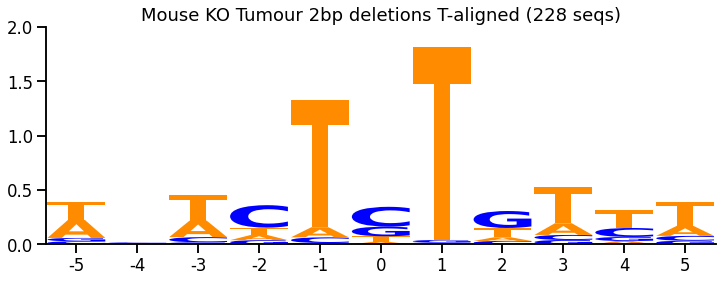

In [8]:
seqs = mouse_2bp_dels.apply(
    lambda x: align_2bp_del_to_nt(x, 'T', 20, grcm38_fa),
    axis=1)
ax = plot_sequence_logo(
    seqs,
    "Mouse KO Tumour 2bp deletions T-aligned",
    save_file=os.path.join(plot_dir,
                           "mouse_tumour_t_aligned.pdf"))

## Reverse complement A (but not T) containing deletions and right-align to 3' most deleted T (if present) - deletions at repeats only

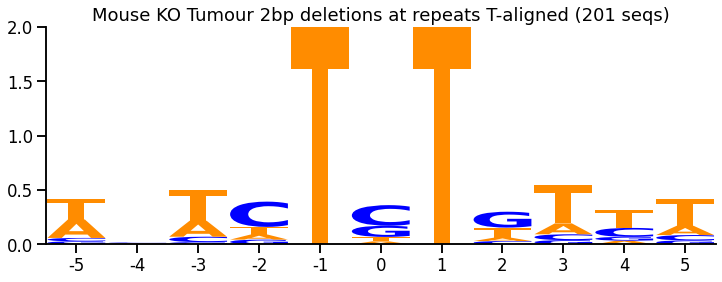

In [9]:
seqs = mouse_2bp_dels[mouse_2bp_dels.repeat_type != 'No repeat'].apply(
    lambda x:  align_2bp_del_to_nt(x, 'T', 20, grcm38_fa), axis=1)
ax = plot_sequence_logo(
    seqs,
    "Mouse KO Tumour 2bp deletions at repeats T-aligned",
    save_file=os.path.join(plot_dir,
                           "mouse_tumour_t_aligned_repeats_only.pdf"))

## Confirm we don't see a similar pattern for deletions of C/G nucleotides

### Reverse complement G (but not C) containing deletions and right-align to 3' most deleted C (if present)

In [10]:
# same algorithm applied to C/G instead of T/C
seqs = mouse_2bp_dels.apply(
    lambda x: align_2bp_del_to_nt(x, 'C', 20, grcm38_fa),
    axis=1)
ax = plot_sequence_logo(
    seqs,
    "Mouse KO Tumour 2bp deletions C-aligned",
    save_file=os.path.join(plot_dir,
                           "mouse_tumour_c_aligned.pdf"))

## Reverse complement G (but not C) containing deletions and right-align to 3' most deleted C (if present) - deletions at repeats only

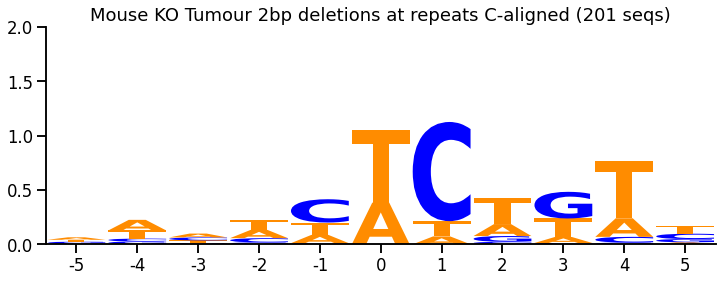

In [11]:
seqs = mouse_2bp_dels[mouse_2bp_dels.repeat_type != 'No repeat'].apply(
    lambda x:  align_2bp_del_to_nt(x, 'C', 20, grcm38_fa), axis=1)
ax = plot_sequence_logo(
    seqs,
    "Mouse KO Tumour 2bp deletions at repeats C-aligned",
    save_file=os.path.join(plot_dir,
                           "mouse_tumour_c_aligned_repeats_only.pdf"))

In [12]:
# create function to apply the above steps to other datasets
def create_sequence_logos(two_bp_dels, cohort_name, ref_fasta, plot_prefix):
    # flipped and right-aligned
    seqs = two_bp_dels.apply(
        lambda x: align_2bp_del_to_nt(x, 'T', 20, ref_fasta, do_not_shift=True),
        axis=1)
    ax = plot_sequence_logo(
        seqs,
        "{} 2bp deletions flipped and right-aligned".format(cohort_name),
        save_file=os.path.join(plot_dir,
                               plot_prefix + "_right_aligned_and_flipped.pdf"))
    # flipped and T-aligned
    seqs = two_bp_dels.apply(
        lambda x: align_2bp_del_to_nt(x, 'T', 20, ref_fasta),
        axis=1)
    ax = plot_sequence_logo(
        seqs,
        "{} 2bp deletions T-aligned".format(cohort_name),
        save_file=os.path.join(plot_dir,
                               plot_prefix + "_t_aligned.pdf"))
    # flipped and T-aligned, repeats only
    seqs = two_bp_dels[two_bp_dels.repeat_type != 'No repeat'].apply(
        lambda x:  align_2bp_del_to_nt(x, 'T', 20, ref_fasta), axis=1)
    ax = plot_sequence_logo(
        seqs,
        "{} 2bp deletions at repeats T-aligned".format(cohort_name),
        save_file=os.path.join(plot_dir,
                               plot_prefix + "_t_aligned_repeats_only.pdf"))

# RPE1 Mutation Accumulation Experiment

RNASEH2A KO (AKO1_4) and RNASEH2B KO (BKO1_4) vs WT RPE1 cells after long term bottleneck culture.

In [13]:
rpe1_indel_df = pd.read_csv("data/rpe1_bottleneck/rpe1_indels.csv")
rpe1_2bp_dels = rpe1_indel_df[(rpe1_indel_df.variant_type == 'Del') &
                              (rpe1_indel_df.variant_length == 2) &
                              (rpe1_indel_df.Status == 'KO')].copy()
rpe1_2bp_dels.head()

chrom        pos   qual  ref alt  n_alleles variant_type repeat_type  \
1   chr1    9715158  420.0  CAG   C          2          Del     Perfect   
7   chr1   65630696  413.0  TTG   T          2          Del     Perfect   
12  chr1  109498641  914.0  CAG   C          2          Del   No repeat   
16  chr1  118693206  408.0  ATC   A          2          Del     Perfect   
17  chr1  151762776  699.0  ACT   A          2          Del   No repeat   

   repeat_unit  repeat_length                                    sequence  \
1           AG              4  tgcactccaacctgggcgacAGagtgggactccatctcaaaa   
7           TG             20  tattttcggtttctttgtttTGtgtgtgtgtgtgtgtgtgtt   
12         NaN              0  cttcctccagctgggatctcAGtggctcccagctgcatgggc   
16          TC              6  tttgtgtccccattatccaaTCtctcttatctcttcctcacc   
17         NaN              0  caggctcctctccccacacaCTgttaatgatgttgctgcctt   

    variant_length cosmic_class  transcribed transcribed_strand  \
1                2    2:Del:R:1         True              Sense   
7                2    2:Del:R:5         True              Sense   
12               2    2:Del:R:0         True              Sense   
16               2    2:Del:R:2        False      Untranscribed   
17               2    2:Del:R:0         True          Antisense   

   Simple_Categorization sample_id Status  
1        2-5 bp deletion    BKO1_4     KO  
7        2-5 bp deletion    BKO1_4     KO  
12       2-5 bp deletion    BKO1_4     KO  
16       2-5 bp deletion    BKO1_4     KO  
17       2-5 bp deletion    BKO1_4     KO

In [14]:
hg38_fasta_path = "ref/hg38/hg38.fa"
hg38_fa = Fasta(hg38_fasta_path, as_raw=True, sequence_always_upper=True)

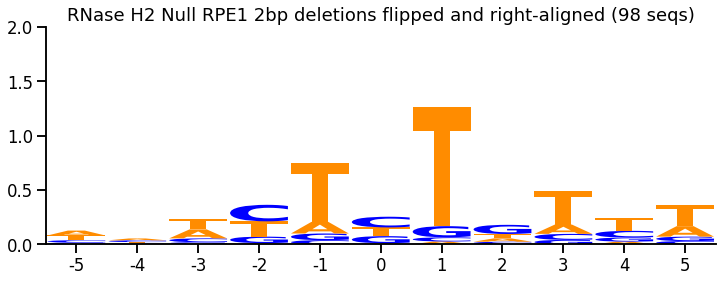

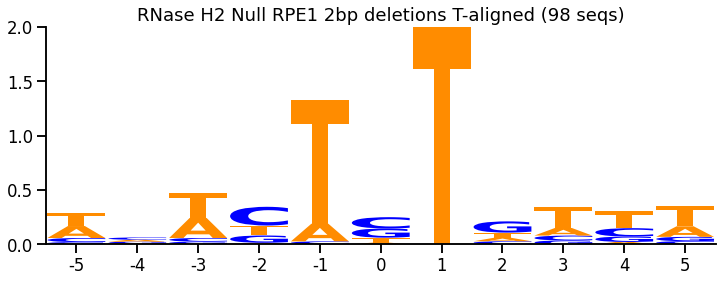

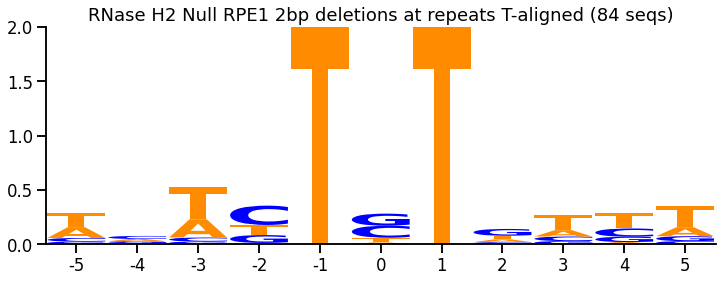

In [15]:
create_sequence_logos(rpe1_2bp_dels, "RNase H2 Null RPE1", hg38_fa, "rpe1")

# Gene4Denovo



In [16]:
g4d_indel_df = pd.read_csv("data/gene4denovo/gene4denovo_indels.csv",
                           dtype={'chrom': str, 'pos': int})
g4d_2bp_dels = g4d_indel_df[(g4d_indel_df.variant_type == 'Del') &
                            (g4d_indel_df.variant_length == 2)].copy()
                            
g4d_2bp_dels.head()

chrom        pos  qual  ref alt  n_alleles variant_type repeat_type  \
11    13  103836884   NaN  CTG   C          2          Del     Perfect   
13     3  144409220   NaN  GAT   G          2          Del   No repeat   
22     X  137789154   NaN  CTA   C          2          Del   Imperfect   
26    11   24779708   NaN  CTA   C          2          Del   No repeat   
27    14   61040808   NaN  GAA   G          2          Del   Imperfect   

   repeat_unit  repeat_length                                    sequence  \
11          TG              6  gtgtgcttgggagttttctcTGtgtgttttgtgtttacaagg   
13         NaN              0  aaaactgactgccttttaggATgtagctaagcagtgtttaga   
22           T              3  acagattcctgttatcaggcTAtgttctttaatggtctttca   
26         NaN              0  aaattctgaataaacaaatcTAagagtatattaacaaaatac   
27           A              3  tgggatatcaggctaatgtgAAatagaagttattctctatgc   

    variant_length cosmic_class  transcribed transcribed_strand  \
11               2    2:Del:R:2        False      Untranscribed   
13               2    2:Del:R:0        False      Untranscribed   
22               2    2:Del:M:1         True          Antisense   
26               2    2:Del:R:0         True              Sense   
27               2    2:Del:M:1        False      Untranscribed   

   Simple_Categorization  
11       2-5 bp deletion  
13       2-5 bp deletion  
22       2-5 bp deletion  
26       2-5 bp deletion  
27       2-5 bp deletion

In [17]:
grch37_fasta_path = "ref/GRCh37/hs37d5.fa"
grch37_fa = Fasta(grch37_fasta_path, as_raw=True, sequence_always_upper=True)

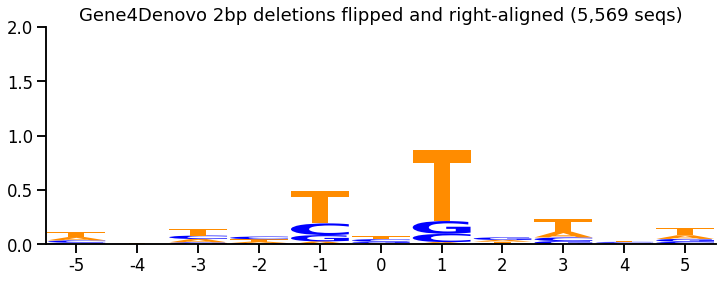

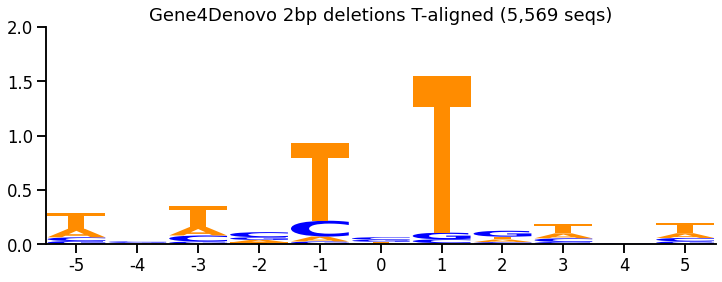

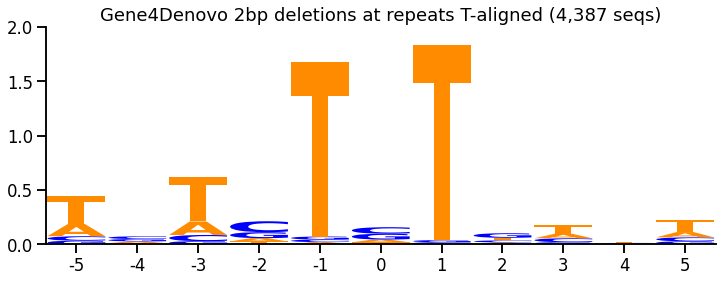

In [18]:
create_sequence_logos(g4d_2bp_dels, "Gene4Denovo", grch37_fa, "gene4denovo")

# rnh201Δ pol2-M644G yeast

In [19]:
yeast_indel_df = pd.read_csv(
    "data/pol2_m644g_rnh201_delta_yeast/pol2_M644G_rnh201_dnms.indels.csv")
yeast_2bp_dels = yeast_indel_df[(yeast_indel_df.variant_type == 'Del') &
                                (yeast_indel_df.variant_length == 2)].copy()
yeast_2bp_dels.head()

chrom     pos         qual  ref alt  n_alleles variant_type  \
0  chr10_ref_v2  173081  1838.859985  AAG   A          2          Del   
1  chr10_ref_v2  173090  1747.859985  TTC   T          2          Del   
3  chr10_ref_v2  190627  1640.859985  CCA   C          2          Del   
4  chr10_ref_v2  233817  6914.589844  AAC   A          2          Del   
5  chr10_ref_v2  262822   926.859985  GTC   G          2          Del   

  repeat_type repeat_unit  repeat_length  \
0     Perfect          AG              6   
1     Perfect          TC              8   
3     Perfect          CA              4   
4     Perfect          AC              4   
5     Perfect          TC              6   

                                     sequence  variant_length cosmic_class  \
0  tgagcaaaatagagaaggaaAGagaggattctctctctgagt               2    2:Del:R:2   
1  tagagaaggaaagagaggatTCtctctctgagtaaaatcgat               2    2:Del:R:3   
3  tggcctccaaacccaggttcCAcagtcataacaagagccata               2    2:Del:R:1   
4  gaatattctttttgtcactaACacaaccattctataaattga               2    2:Del:R:1   
5  cttttcgtatccggcatttgTCtctctgaagaaacatccatg               2    2:Del:R:2   

  Simple_Categorization  
0       2-5 bp deletion  
1       2-5 bp deletion  
3       2-5 bp deletion  
4       2-5 bp deletion  
5       2-5 bp deletion

In [20]:
gse_fasta_path = "ref/GSE56939_L03_ref_v2/GSE56939_L03_ref_v2.fa"
gse_fa = Fasta(gse_fasta_path, sequence_always_upper=True, as_raw=True)

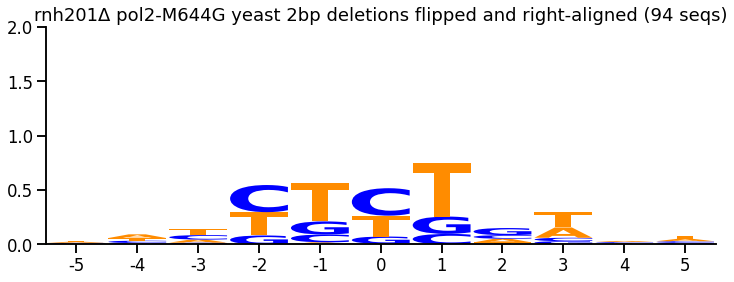

In [21]:
create_sequence_logos(yeast_2bp_dels, "rnh201Δ pol2-M644G yeast", gse_fa,
                      "pol2_M644G_rnh201")